In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
# G = c = 1

In [4]:
# Working in manual cgs units here. 
   
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

def _dPhidr(r, P, M):
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return num/dem

def _dPdr(r, P, M, e):
    factor = -G/(c**2) 
    term1 = (e+P) 
    dphidr = _dPhidr(r, P, M)
    return factor * term1 * dphidr

def coupledTOV(r, VEC, f_e_smooth):
    P, M, phi = VEC
    e = f_e_smooth(P)
    
    dMdr = _dMdr(r, e)
    dPhidr = _dPhidr(r, P, M)
    dPdr = _dPdr(r, P, M, e)
    ret = [dPdr, dMdr, dPhidr]
#     print(ret)
    return ret

In [5]:
def df_to_ep(df):
    n_den = 2.3e14
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*(c**2)
    pressure = p*(c**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value="extrapolate")
    return f_e_smooth

In [6]:
def tov(ep, init_VEC, r_i, p_min, progress = False):
    func = ep

    r = ode(lambda r, VEC: coupledTOV(r, VEC, func)).set_integrator('LSODA')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
    # max_iter = 1000000 # Change back to this if "Excess work done on this call" error. 
    max_iter = 100000

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] >= p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)
        
        results.append(integral)
        r_list.append(r.t+dr_init)

    #     dr_compute = r * dP /P 

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
    
    if progress:
        pbar.close()
        
#     print(r.successful() , (r.y[0] > p_min))
#     print(r)
    
    results = np.array(results, dtype = float)
    p, m, phi = results.T
    r = np.array(r_list)
    return p, m, r, phi

In [7]:
# Load EOS
df = pd.read_csv("sly230a.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1e-8 # This needs to be low enough for additional p0 term to not have any effect. 
p0 = p[-8]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**2)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = e0
m0 = e_c * 4/3 * np.pi * r_i**3

phi0 = 1 #Arbitrary guess 

init_VEC = [p_c, m0, phi0]
msun = 2e33
p_min = min(p)

# Integrate
p, m, r_arr, phi = tov(EOS, init_VEC, r_i, p_min, progress = True)
r_arr = r_arr/km2cm
m = m/msun

mStar = m.max()
max_idx = np.argmax(m)
mR = r_arr[max_idx]

# Convert back to cgs for calculations
M = mStar * msun
R = mR * km2cm 

# Working in scale
schild = np.log((1-2*G*M/(c**2*R)))
interior = (2*phi[-1])

print("== First Integration == ")
print(f"Star has mass {mStar:.1f} Msun and radius {mR:.1f}km")
print(f"Interior Surface: {interior:.2e}")
print(f"Exterior Surface: {schild:.2e}")
print(f"Phi0 Round 1: {phi0}")

# Log base e
phi0_schild = 0.5 * schild
phi0_new =  - phi[-1]
phi0_new = -1.0542525e28


# Repeat integration
init_VEC = [p_c, m0, phi0_new]
msun = 2e33
p_min = min(p)

time.sleep(0.2)
# Integrate
p, m, r_arr, phi = tov(EOS, init_VEC, r_i, p_min, progress = True)
r_arr = r_arr/km2cm
m = m/msun

mStar = m.max()
max_idx = np.argmax(m)
mR = r_arr[max_idx]

# Working in scale
schild = np.log((1-2*G*M/(c**2*R)))
interior = (2*phi[-1])
print("== Repeated Integration == ")
print(f"Star has mass {mStar:.1f} Msun and radius {mR:.1f}km")
print(f"Interior Surface: {interior:.2e}")
print(f"Exterior Surface: {schild:.2e}")
print(f"Phi0 Round 2: {phi0_new}")

 50%|████▉     | 49830/100000 [00:00<00:00, 70882.91it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
 51%|█████     | 50958/100000 [00:00<00:00, 59749.48it/s]


== First Integration == 
Star has mass 2.1 Msun and radius 10.2km
Interior Surface: 2.11e+28
Exterior Surface: -9.37e-01
Phi0 Round 1: 1


 51%|█████     | 50958/100000 [00:00<00:00, 61574.34it/s]

== Repeated Integration == 
Star has mass 2.1 Msun and radius 10.2km
Interior Surface: -9.56e+20
Exterior Surface: -9.37e-01
Phi0 Round 2: -1.0542525e+28


## Solving Iteratively

In [36]:
from scipy.optimize import minimize
# Load EOS
df = pd.read_csv("sly230a.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1e-8 # This needs to be low enough for additional p0 term to not have any effect. 
p0 = p[-8]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**2)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = e0
m0 = e_c * 4/3 * np.pi * r_i**3

phi0 = 1 #Arbitrary guess 


def minimize_phi(phi0_new, p = p, EOS = EOS):
    # Repeat integration
    init_VEC = [p_c, m0, phi0_new]
    msun = 2e33
    p_min = min(p)

    # Integrate
    p, m, r_arr, phi = tov(EOS, init_VEC, r_i, p_min, progress = False)
    r_arr = r_arr/km2cm
    m = m/msun

    mStar = m.max()
    max_idx = np.argmax(m)
    mR = r_arr[max_idx]

    # Working in scale
    schild = np.log((1-2*G*M/(c**2*R)))
    interior = (2*phi[-1])
    loss = (schild - interior)**2
    print(f"{loss:.4e}")
    return loss

res = minimize(minimize_phi, x0 = 1e28, method = "Nelder-Mead", options = {"disp": True}, tol = 1e30)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


1.6880e+57
1.7711e+57
1.6068e+57
1.5276e+57
1.3753e+57
1.2310e+57
9.6628e+56
7.3360e+56
3.6424e+56
1.2288e+56
2.4157e+55
4.3744e+56
4.3744e+56
9.5176e+54
1.2288e+56
8.3713e+53
2.4157e+55
1.1773e+54
8.4971e+54
7.2337e+51
1.1773e+54
1.7216e+53
3.4228e+53
2.7210e+52
1.1230e+53
1.5964e+51
2.7210e+52
5.0823e+50
7.2337e+51
7.5738e+49
1.5964e+51
4.7934e+49
5.0820e+50
7.9713e+47
7.5744e+49
9.0850e+48
2.2991e+49
1.1274e+48
8.0695e+48
7.3631e+45
1.1274e+48
1.6232e+47
3.2881e+47
2.4713e+46
1.0823e+47
1.1191e+45
2.3953e+46
6.4320e+44
7.4547e+45
3.3603e+43
1.1191e+45
8.7997e+43
3.5179e+44
6.8162e+42
8.7997e+43
3.5077e+40
3.3603e+43
2.2271e+42
7.6516e+42
4.6011e+41
2.2488e+42
1.8913e+37
4.6011e+41
2.7445e+42
2.7445e+42
9.6848e+41
2.9209e+40
8.3509e+41
1.4381e+38
Optimization terminated successfully.
         Current function value: 18913245761621493561497957589154004992.000000
         Iterations: 34
         Function evaluations: 69


In [38]:
phi0_optimized = res.x

# Repeat integration
init_VEC = [p_c, m0, phi0_optimized]
msun = 2e33
p_min = min(p)

time.sleep(0.2)
# Integrate
p, m, r_arr, phi = tov(EOS, init_VEC, r_i, p_min, progress = True)
r_arr = r_arr/km2cm
m = m/msun

mStar = m.max()
max_idx = np.argmax(m)
mR = r_arr[max_idx]

# Working in scale
schild = np.log((1-2*G*M/(c**2*R)))
interior = (2*phi[-1])
print("== Repeated Integration == ")
print(f"Star has mass {mStar:.1f} Msun and radius {mR:.1f}km")
print(f"Interior Surface: {interior:.2e}")
print(f"Exterior Surface: {schild:.2e}")
print(f"Phi0 Round 2: {phi0_new}")

 51%|█████     | 50622/100000 [00:00<00:00, 66911.60it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
 51%|█████     | 50958/100000 [00:00<00:00, 61440.91it/s]

== Repeated Integration == 
Star has mass 2.1 Msun and radius 10.2km
Interior Surface: -4.35e+18
Exterior Surface: -9.37e-01
Phi0 Round 2: -1.0542525e+28


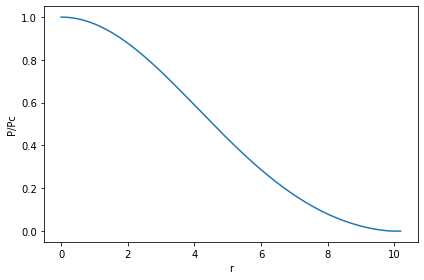

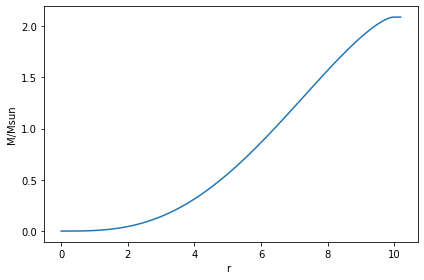

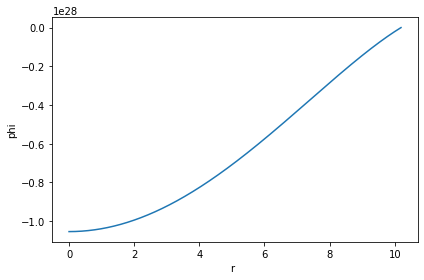

In [39]:
plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()